In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#initialize dataframes
df = pd.read_csv('General_Sedan.csv', index_col=0)
df.head()

,date,message,time,username
0,2002-03-23,Entry level performance luxury sedans are a ho...,19:04:32,cybersol
1,2002-03-25,I personally think that with a few tweaks the ...,05:54:02,merc1
2,2002-03-25,I am debating a new purchase and these two are...,07:06:29,fredvh
3,2002-03-25,"Great handling, RWD, excellent engine and the ...",17:02:27,blueguydotcom
4,2002-03-25,And no manual tranny. That may not matter to ...,23:04:37,hungrywhale


In [4]:
#initialize brand data, remove weird values

model_df = pd.read_csv('Cars make model list.csv', encoding='utf-8', names=['brand', 'model'])
model_df['brand'] = model_df['brand'].str.lower()
model_df['model'] = model_df['model'].str.lower()

model_dict = model_df.set_index('model')['brand'].to_dict()
model_df.head()

,brand,model
0,acura,integra
1,acura,legend
2,acura,vigor
3,acura,rlx
4,acura,ilx


In [5]:
# add dummy row of data 
allbrands = ' '.join([word for word in model_df['brand'].unique()])

df.loc[-1] = [np.nan, allbrands, np.nan, np.nan]  # adding a row
df.index = df.index + 1  # shifting index
df.sort_index(inplace=True)
df.head()

,date,message,time,username
0,NaN,acura audi bmw buick cadillac car chevrolet ch...,NaN,NaN
1,2002-03-23,Entry level performance luxury sedans are a ho...,19:04:32,cybersol
2,2002-03-25,I personally think that with a few tweaks the ...,05:54:02,merc1
3,2002-03-25,I am debating a new purchase and these two are...,07:06:29,fredvh
4,2002-03-25,"Great handling, RWD, excellent engine and the ...",17:02:27,blueguydotcom


In [6]:
# Define function to remove unnecessary characters from words
from nltk import pos_tag, word_tokenize
def remove_weird_char(string):
    import re
    string = string.lower()
    words = string.split()
    refined = []
    for i in words:
        refined.append(re.sub("[^\w]+", " ", i))
    sentence = ' '.join([word for word in refined])
    return(sentence)

#define function to replace brand references with model references
def replace_brand(text):
    aset = set(text.split())
    overlap = aset.intersection(set(model_dict.keys()))
    aset = (aset-overlap).union(set([model_dict[x] for x in overlap]))
    return ' '.join([word for word in aset])

# Define function to remove stopwords from given text
# also removes duplicate words in a single message
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")
def rmStopWords(text):
        text = ' '.join([word for word in set(text.split()) if word not in cachedStopWords])
        return text
    
#define function to replace some punctuation with spaces
def rep_punct(text):
    return text.lower().replace('.',' ').replace('!',' ').replace(',',' ').replace('?',' ').replace(')',' ').replace('(',' ')

# Define function to remove unnecessary characters from words
from nltk import pos_tag, word_tokenize
def remove_weird_char(string):
    import re
    string = string.lower()
    words = string.split()
    refined = []
    for i in words:
        refined.append(re.sub("[^\w]+", " ", i))
    sentence = ' '.join([word for word in refined])
    return(sentence)

In [7]:
# process comments with above functions

df['fixedmessage'] = df['message'].apply(rep_punct).apply(replace_brand).apply(rmStopWords).apply(remove_weird_char)

In [8]:
# Slice dataframe to get relevant column
messages = df['fixedmessage'].str.cat(sep=" ")

# Tokenize, tag, and turn into a dataframe
pos_df = pd.DataFrame(pos_tag(word_tokenize(messages)), columns = ['Word', 'POS'])

In [9]:
# top brands by number of mentions (by message)
brands = set(model_dict.values())
relevant_brands = brands-{'car','seat','sedan','problem'}

top_10_brands = pos_df[pos_df['Word'].isin(relevant_brands)]['Word'].value_counts()[:10].index
pos_df[pos_df['Word'].isin(relevant_brands)]['Word'].value_counts()[:10]

bmw         3888
infiniti    2393
audi        2393
acura       1496
mercedes     899
cadillac     898
toyota       898
chrysler     599
buick        599
lincoln      300
Name: Word, dtype: int64

# Task A

In [10]:
#calculate lift values

def calc_lift(a, b):
    total_size = len(df)
    filter_a = df[df['fixedmessage'].str.contains(a)]
    num_a = len(filter_a)
    num_b = len(df[df['fixedmessage'].str.contains(b)])
    num_a_b = len(filter_a['fixedmessage'][filter_a['fixedmessage'].str.contains(b)])
    if num_a_b==0:
        return .2
    return total_size*float(num_a_b)/float(num_a*num_b)

In [11]:
#function to uniquely combine relevant brands
def permute(aset):
    alist = []
    for item1 in aset:
        for item2 in aset-{item1}:
            newset = {item1, item2}
            if newset not in alist:
                alist.append(newset)
    
    return alist

In [12]:
# make dataframe of lift values
aset = list(top_10_brands)
test_df = pd.DataFrame(columns=aset, index=aset)

for brand1, series in list(test_df.iterrows()):
    for brand2 in series.index:
        test_df[brand2].loc[brand1] = calc_lift(brand1, brand2)

test_df

,bmw,infiniti,audi,acura,mercedes,cadillac,toyota,chrysler,buick,lincoln
bmw,2.81763,1.76146,2.01298,1.69133,2.81763,2.81763,0.941302,2.81763,1.41117,2.81763
infiniti,1.76146,3.8738,1.66126,1.55107,1.94013,2.58397,0.00431381,1.94013,0.00646711,3.8738
audi,2.01298,1.66126,4.42693,2.65734,4.42693,2.95293,1.47893,4.42693,2.21716,0.0147564
acura,1.69133,1.55107,2.65734,6.19652,6.19652,2.07011,2.07011,6.19652,3.10343,0.0206551
mercedes,2.81763,1.94013,4.42693,6.19652,15.4758,5.17009,5.17009,15.4758,7.75081,0.051586
cadillac,2.81763,2.58397,2.95293,2.07011,5.17009,10.3229,0.0114955,5.17009,0.0172336,10.3229
toyota,0.941302,0.00431381,1.47893,2.07011,5.17009,0.0114955,10.3229,5.17009,5.17009,0.0344098
chrysler,2.81763,1.94013,4.42693,6.19652,15.4758,5.17009,5.17009,15.4758,7.75081,0.051586
buick,1.41117,0.00646711,2.21716,3.10343,7.75081,0.0172336,5.17009,7.75081,15.4758,0.051586
lincoln,2.81763,3.8738,0.0147564,0.0206551,0.051586,10.3229,0.0344098,0.051586,0.051586,30.9


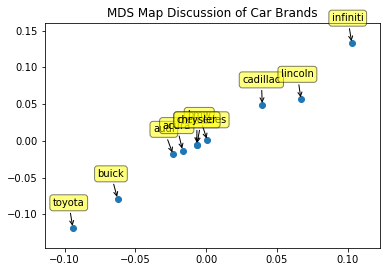

In [13]:
#make dissimilarity matrix and plot
dissimilarity = 1/test_df

import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

adist = np.array(dissimilarity)
amax = np.amax(adist)
adist /= amax

mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)

coords = results.embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
plt.title('MDS Map Discussion of Car Brands')
for label, x, y in zip(dissimilarity.columns.values, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=.3', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

# Task B


In [16]:
top_5_attributes = ['manual', 'performance', 'luxury', 'price', 'handling']
brands_midcluster = ['bmw','infiniti','audi','acura','chrysler']
brands_midcluster = array(brands_midcluster)

midcluster_df = pd.DataFrame(columns=brands_midcluster, index=top_5_attributes)

for attribute, series in list(midcluster_df.iterrows()):
    for brand in series.index:
        midcluster_df[brand].loc[attribute] = calc_lift(brand, attribute)

midcluster_df

,bmw,infiniti,audi,acura,chrysler
manual,1.40881,1.1068,0.632419,0.442609,0.2
performance,1.64362,0.96845,1.47564,1.54913,2.5793
luxury,1.76102,1.45267,2.21347,2.3237,3.86895
price,1.61007,1.6602,1.89726,3.54087,4.42166
handling,2.2541,1.54952,3.54155,3.71791,6.19032


In [17]:
print '\n', midcluster_df.idxmax(axis=0)


bmw         handling
infiniti       price
audi        handling
acura       handling
chrysler    handling
dtype: object


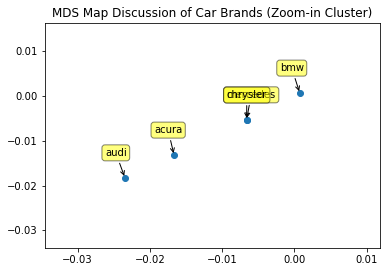

In [18]:
cluster_interest = coords[(coords[:,0] < 0.03) & (coords[:,0] > -0.03)]
cluster_interest_labels = ['bmw','audi','acura',
                          'mercedes','chrysler']
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    cluster_interest[:, 0], cluster_interest[:, 1], marker = 'o'
    )
plt.title('MDS Map Discussion of Car Brands (Zoom-in Cluster)')
for label, x, y in zip(cluster_interest_labels, cluster_interest[:, 0], cluster_interest[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=.3', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()

### Insights for Task B

BMW, Audi, Acura, and Mercedes are luxury European and Japanese brands. Chrysler identified itself as a mainstream brand, but appears in the same cluster. Furthermore, its the only American brand in the cluster. A reason for people to associate Chrysler with these brands may be the fact that they were trying to market themselves as 'affordable luxury' in 2016, and also launched a five year plan for their goals.
On deep diving into this middle cluster, we find that Infiniti is the only brand that is associated most with price, whereas the other brands are associated most with handling.

# Task C

In [19]:
#find most frequent words which aren't brands, then inspect visually

mask = pos_df['Word'].str.len()>2
mask2 = ~pos_df['Word'].isin(brands)

pos_df[mask&mask2]['Word'].value_counts()[:20]

manual         4186
drive          4186
performance    3588
g35            3588
don            3289
get            2990
lexus          2691
think          2392
luxury         2392
one            2392
even           2392
great          2093
price          2093
would          2093
never          1794
new            1794
buy            1794
handling       1794
automatic      1794
es300          1794
Name: Word, dtype: int64

In [20]:
top_5_attributes = ['manual', 'performance', 'luxury', 'price', 'handling']
top_5_brands = pos_df[pos_df['Word'].isin(relevant_brands)]['Word'].value_counts()[:5].index

#add another dummy row of data
fixed_brands_with_att = df.iloc[0]['fixedmessage']+' '.join([word for word in top_5_attributes])

df.loc[-1] = [np.nan, fixed_brands_with_att, np.nan, np.nan, fixed_brands_with_att]  # adding a row
df.index = df.index + 1  # shifting index
df.sort_index(inplace=True)
df.head()

,date,message,time,username,fixedmessage
0,NaN,toyata seat subaru buick audi mercury saturn c...,NaN,NaN,toyata seat subaru buick audi mercury saturn c...
1,NaN,acura audi bmw buick cadillac car chevrolet ch...,NaN,NaN,toyata seat subaru buick audi mercury saturn c...
2,2002-03-23,Entry level performance luxury sedans are a ho...,19:04:32,cybersol,selection show lexus group personal 0 0 60 es3...
3,2002-03-25,I personally think that with a few tweaks the ...,05:54:02,merc1,tl s retuned less money personally anyway year...
4,2002-03-25,I am debating a new purchase and these two are...,07:06:29,fredvh,approx co non type don t generation appreciate...


In [21]:
attribute_df = pd.DataFrame(columns=top_5_brands, index=top_5_attributes)

for attribute, series in list(attribute_df.iterrows()):
    for brand in series.index:
        attribute_df[brand].loc[attribute] = calc_lift(brand, attribute)
        
attribute_df

,bmw,infiniti,audi,acura,mercedes
manual,1.40887,1.10712,0.633091,0.443734,0.00369039
performance,1.64362,0.968959,1.47592,1.54956,2.57887
luxury,1.76111,1.45324,2.21357,2.32401,3.86776
price,1.61033,1.66074,1.89776,3.54015,4.42003
handling,2.25404,1.55059,3.54083,3.71749,6.18686


In [22]:
attribute_df.idxmax(axis=0)

bmw         handling
infiniti       price
audi        handling
acura       handling
mercedes    handling
dtype: object

BMW is most associated with handling in the Edmunds messages, however they cannot claim to be the 'ultimate driving machine' as all brands except Infiniti have a higher handling lift score than BMW's. Therefore, BMW is the 4th most likely brand to be mentioned with handling.

# Task D

We can advice brand managers of the top 5 brands (BMW, Inifiniti, Acura, Audi, Toyota) to focus on improving the attributes/features that the public least associates them with (lift values less than 1)
To the Marketing Managers, we can suggest that they allocate funds/resources efficiently by taking the focus away from the attributes that people associate with them anyway, and bring more light to the features that aren't being talked about. For example, Infiti is well associated with luxury, price, and handling. So it would be more effective to target their marketing strategies towards performance(lift values less than 1) to convey an image of 'new and improved' cars.

# Task E

In [23]:
desire_words = ['want', 'desire', 'wish', 'need', 'crave', 'longing', 'thirst']

#define function to replace some synonyms
def synonym_sentiment(text):
    aset = set(text.split())
    overlap = aset.intersection(set(desire_words))
    aset = (aset-overlap).union('want')
    return ' '.join([word for word in aset])

In [24]:
df['new_fixed_message'] = df['fixedmessage'].apply(synonym_sentiment)

In [25]:
want_matrix = ['want','swag'] + top_5_attributes
new_test_df = pd.DataFrame(columns=top_10_brands, index=want_matrix)

for attribute, series in list(new_test_df.iterrows()):
    for brand in series.index:
        new_test_df[brand].loc[attribute] = calc_lift(brand, attribute)
        
new_test_df

,bmw,infiniti,audi,acura,mercedes,cadillac,toyota,chrysler,buick,lincoln
want,1.40854,0.645433,0.73755,1.03218,2.57528,1.71876,1.71876,2.57528,5.15056,5.13344
swag,2.81708,3.8726,4.4253,6.19305,15.4517,10.3126,10.3126,15.4517,15.4517,30.8007
manual,1.40887,1.10712,0.633091,0.443734,0.00369039,0.738899,0.002463,0.00369039,1.10712,2.20688
performance,1.64362,0.968959,1.47592,1.54956,2.57887,1.72116,0.862015,2.57887,1.29159,0.00858196
luxury,1.76111,1.45324,2.21357,2.32401,3.86776,2.58137,1.29284,3.86776,1.93711,0.0128712
price,1.61033,1.66074,1.89776,3.54015,4.42003,1.47745,2.94997,4.42003,2.21371,0.014709
handling,2.25404,1.55059,3.54083,3.71749,6.18686,4.12916,2.06803,6.18686,3.0986,0.0205887
